# **1 Importing libraries**

In [ ]:
#connecting the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries 
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import random 
import cv2

import tensorflow as tf
from tensorflow import keras

import os,glob,PIL
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense,Flatten, Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam

#**2 Data preparation**

In [ ]:
#making variables of the data diretories 
train_dir = "/content/drive/MyDrive/Covid19-dataset/train"
test_dir = "/content/drive/MyDrive/Covid19-dataset/test"

In [ ]:
#splitting the train_dataset into train  and shaping it into an adequate 224,224 size for VGG19 
image_h,image_w = 224,224
size_batch = 32
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.20,
    subset = "training",
    seed = 123,
    label_mode = "categorical",
    image_size=(image_h,image_w),
    batch_size = size_batch
)

Found 251 files belonging to 3 classes.
Using 201 files for training.


In [ ]:
#splitting the train_dataset into validation dataset,shaping it into 224,224 sizes for VGG19
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.20,
    subset = "validation",
    seed = 123,
    label_mode = "categorical",
    image_size=(image_h,image_w),
    batch_size = size_batch
)

Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [ ]:
#test_dataset shaping it into 224,224 sizes for VGG19
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = 123,
    label_mode = "categorical",
    image_size=(image_h,image_w),
    batch_size = size_batch
)

Found 66 files belonging to 3 classes.


In [ ]:
label_names = train_dataset.class_names
label_names

['Covid', 'Normal', 'Viral Pneumonia']

In [ ]:
label_names_test = test_dataset
label_names

['Covid', 'Normal', 'Viral Pneumonia']

# **3 Adding the pre-trained model and the additional layers**

In [ ]:
from keras.applications import VGG19
#creating the model 
VGG19_model = Sequential()

#using keras VGG19 as base pre-trained model with softmax activation becasue we need multiclass classification as there are 3 cathegories
standard_model= tf.keras.applications.VGG19(
    include_top= False,
    input_shape=(224,224,3),
    input_tensor=None,
    weights="imagenet",
    pooling = None,
    classes = 3,
    classifier_activation="softmax"
    )

#creating a loop to instruct the layers to not be trainable
for layer in standard_model.layers:
  layer.trainable=False

#adding the additional layers to the model 
VGG19_model.add(standard_model)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(512,activation="relu"))
VGG19_model.add(Dense(3,activation="softmax"))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
VGG19_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 12,847,107
Non-trainable params: 20,024,384
_________________________________________________________________


#**4 Training the Model** 

In [ ]:
#compiling the model 
VGG19_model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
#training the model with the train_dataset and 10 epochs
epochs = 10
h = VGG19_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 224s 29s/step - loss: 103.2733 - accuracy: 0.4975 - val_loss: 35.2159 - val_accuracy: 0.7400
Epoch 2/10
7/7 [==============================] - 201s 29s/step - loss: 15.1470 - accuracy: 0.9005 - val_loss: 26.5397 - val_accuracy: 0.9200
Epoch 3/10
7/7 [==============================] - 195s 28s/step - loss: 6.9254 - accuracy: 0.9552 - val_loss: 23.9312 - val_accuracy: 0.9200
Epoch 4/10
7/7 [==============================] - 199s 29s/step - loss: 0.9103 - accuracy: 0.9801 - val_loss: 12.8150 - val_accuracy: 0.9200
Epoch 5/10
7/7 [==============================] - 204s 29s/step - loss: 0.3509 - accuracy: 0.9950 - val_loss: 10.3088 - val_accuracy: 0.9400
Epoch 6/10
7/7 [==============================] - 197s 28s/step - loss: 0.0697 - accuracy: 0.9950 - val_loss: 9.9507 - val_accuracy: 0.9400
Epoch 7/10
7/7 [==============================] - 199s 28s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 10.1290 - val_accuracy: 0.9400
Epoch 8

# **5 Testing the model's accuracy and loss**

In [ ]:
#testing the model and printing the accuracy
results = VGG19_model.evaluate(test_dataset,batch_size=size_batch,verbose=1)
print("CNN Accuracy: %.2f%%" % (results[1] *100))


3/3 [==============================] - 63s 14s/step - loss: 7.8531 - accuracy: 0.9242
CNN Accuracy: 92.42%


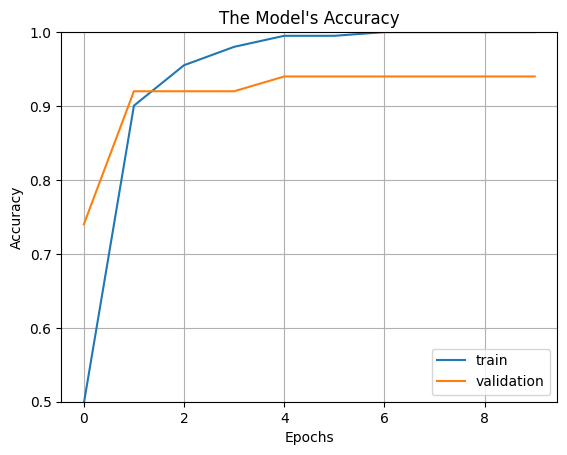

In [ ]:
#plotting the model's accuracy vs the epochs
figure_1 = plt.gcf()
plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])
plt.axis(ymin=0.5,ymax=1)
plt.grid()
plt.title("The Model's Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train","validation"])
plt.show()

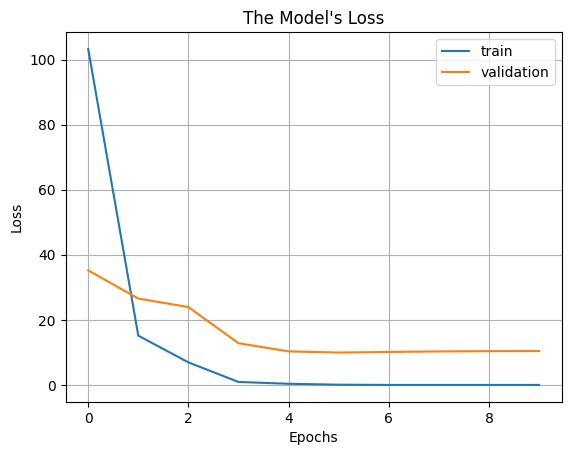

In [ ]:
#plotting the model's loss vs the epochs 
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.grid()
plt.title("The Model's Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train","validation"])
plt.show()

# **6 Making Predictions**

##**6.1 Creating list of all test images**

In [ ]:
#making a directory for covid images
path_covid = glob.glob("/content/drive/MyDrive/Covid19-dataset/test/Covid/*")
#making a list of covid images using glob, sing the cv2.imread() functon to read image from director
#and reshaping it + making it four dimensional 
all_covid_imgs = []
for img in path_covid:
  n = cv2.imread(str(img))
  img_resized = cv2.resize(n,(image_h,image_w))
  n = np.expand_dims(img_resized,axis=0)
  all_covid_imgs.append(n)

In [ ]:
path_normal = glob.glob("/content/drive/MyDrive/Covid19-dataset/test/Normal/*")
all_normal_imgs = []
for img in path_normal:
  n = cv2.imread(str(img))
  img_resized = cv2.resize(n,(image_h,image_w))
  n = np.expand_dims(img_resized,axis=0)
  all_normal_imgs.append(n)

In [ ]:
path_viral = glob.glob("/content/drive/MyDrive/Covid19-dataset/test/Viral Pneumonia/*")
all_viral_imgs = []
for img in path_viral:
  n = cv2.imread(str(img))
  img_resized = cv2.resize(n,(image_h,image_w))
  n = np.expand_dims(img_resized,axis=0)
  all_viral_imgs.append(n)

##**6.2 Creating lists of predictions on images**

In [ ]:
#creating a list for all_covid_predictions
prediction_all_covid = []
#predicting all images with the VGG19 model
for img in all_covid_imgs:
  prediction = VGG19_model.predict(img)
  prediction_all_covid.append(prediction)

In [ ]:
prediction_all_normal = []

for img in all_normal_imgs:
  prediction = VGG19_model.predict(img)
  prediction_all_normal.append(prediction)

In [ ]:
prediction_all_viral = []

for img in all_viral_imgs:
  prediction = VGG19_model.predict(img)
  prediction_all_viral.append(prediction)

In [ ]:
#creating list for the labels of predicted images
output_class_all_covid_pred = []
#adding the labels of predicted images into the list using numpy.argmax
for pred in prediction_all_covid:
  output=label_names[np.argmax(pred)]
  output_class_all_covid_pred.append(output)

In [ ]:
output_class_all_normal_pred = []

for pred in prediction_all_normal:
  output=label_names[np.argmax(pred)]
  output_class_all_normal_pred.append(output)

In [ ]:
output_class_all_viral_pred = []

for pred in prediction_all_viral:
  output=label_names[np.argmax(pred)]
  output_class_all_viral_pred.append(output)

In [ ]:
#printing out the labels for all predictions to see false positives
print(output_class_all_covid_pred)
print(output_class_all_normal_pred)
print(output_class_all_viral_pred)

['Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Normal', 'Covid', 'Covid']
['Normal', 'Normal', 'Normal', 'Viral Pneumonia', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia']
['Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia']


In [ ]:
#making labels for all actual images 
output_class_all_covid_actual = []
for actual in all_covid_imgs:  
  output_class_all_covid_actual.append("Covid")

In [ ]:
output_class_all_normal_actual = []
for actual in all_normal_imgs:  
  output_class_all_normal_actual.append("Normal")

In [ ]:
output_class_all_viral_actual = []
for actual in all_viral_imgs:  
  output_class_all_viral_actual.append("Viral")

#**7 Evaluation**

In [ ]:
#adding the list of labels together to be able to compare 
actual = []
actual = output_class_all_covid_actual + output_class_all_normal_actual + output_class_all_viral_actual

predicted = []
predicted = output_class_all_covid_pred + output_class_all_normal_pred + output_class_all_viral_pred

##**7.1 Confusion matrix**

In [ ]:
#importing libraries
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#making the confusion matrix using the all actual and all predicted labels
confusion = confusion_matrix(actual,predicted)

In [ ]:
#creating a dataframe using the confusion matrix's results and adding columns and rows
confusion_df = pd.DataFrame(confusion,
                            index = ["Covid","Normal","Viral",""],
                            columns = ["Covid","Normal","","Viral"]
                            )

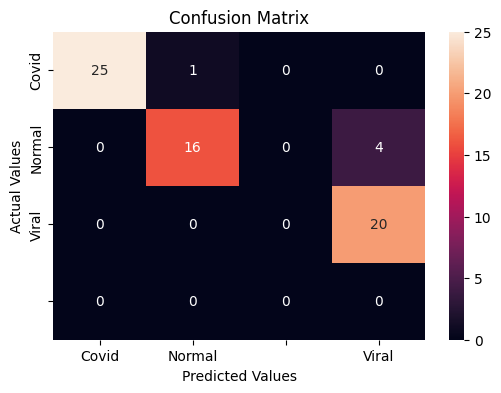

In [ ]:
#plotting the confusion matrix results using seaborn
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(confusion_df,annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

##**7.2 Precision, Recall, F1-score**

In [ ]:
#using the sklearn.metrics for precision, recall, and F1-score
print('Weighted Precision Covid: {:.2f}'.format(precision_score(output_class_all_covid_actual, output_class_all_covid_pred, average='weighted')))
print('Weighted Precision Normal: {:.2f}'.format(precision_score(output_class_all_normal_actual, output_class_all_normal_pred, average='weighted')))
print('Weighted Precision Viral: {:.2f}'.format(precision_score(output_class_all_viral_actual, output_class_all_viral_pred, average='weighted',zero_division=1)))

print('\nWeighted Recall Covid: {:.2f}'.format(recall_score(output_class_all_covid_actual, output_class_all_covid_pred, average='weighted',zero_division=1)))
print('Weighted Recall Normal: {:.2f}'.format(recall_score(output_class_all_normal_actual, output_class_all_normal_pred, average='weighted',zero_division=1)))
print('Weighted Recall Viral: {:.2f}'.format(recall_score(output_class_all_viral_actual, output_class_all_viral_pred, average='macro',zero_division=1)))

print('\nWeighted F1-score Covid: {:.2f}'.format(f1_score(output_class_all_covid_actual, output_class_all_covid_pred, average='weighted')))
print('Weighted F1-score Normal: {:.2f}'.format(f1_score(output_class_all_normal_actual, output_class_all_normal_pred, average='weighted')))
print('Weighted F1-score Viral: {:.2f}'.format(f1_score(output_class_all_viral_actual, output_class_all_viral_pred, average='weighted')))

Weighted Precision Covid: 1.00
Weighted Precision Normal: 1.00
Weighted Precision Viral: 1.00

Weighted Recall Covid: 0.96
Weighted Recall Normal: 0.80
Weighted Recall Viral: 0.50

Weighted F1-score Covid: 0.98
Weighted F1-score Normal: 0.89
Weighted F1-score Viral: 0.00
